
# TensorFlow Practice
**Goal:** Read and write low‑level TensorFlow (TF1‑style) code that mirrors our scratch implementations, then apply it to multiple datasets (Iris binary, Iris 3‑class, House Prices regression, MNIST).


In [2]:
# Environment glue: make TF2 behave like TF1 (placeholders & sessions)
import os, sys, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix

#!pip install tensorflow
import tensorflow as _tf
if _tf.__version__.startswith("2"):
    tf = _tf.compat.v1
    _tf.compat.v1.disable_eager_execution()
else:
    tf = _tf

np.random.seed(42)  # reproducibility (splits, synthetic ops, etc.)
print("TensorFlow version:", _tf.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 114.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 128.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.1 MB/s eta 0:00:00
TensorFlow version: 2.20.0


## Question 1 Looking back at Scratch - what did we need?
From our scratch work, a minimal deep learning pipeline needed:
- **Parameter initialization** (weights/biases; e.g., Gaussian/Xavier/He).
- **Forward pass** (linear layers / activations / softmax / loss).
- **Loss function** (e.g., cross‑entropy for classification, MSE for regression).
- **Backpropagation** (compute gradients w.r.t. all parameters).
- **Optimizer / update rule** (SGD/AdaGrad/Adam, apply gradients).
- **Mini‑batches** (iterator over shuffled chunks).
- **Training loop** (epoch/iteration structure; logging; early stopping optional).
- **Evaluation** (metrics on val/test; accuracy/RMSE; confusion matrix).
- **Preprocessing** (scaling/standardization; one‑hot; train/val/test split).


## Question 2 Scratch ↔ TensorFlow mapping
| Scratch concept | TensorFlow (low‑level) analog |
|---|---|
| Arrays (NumPy) | Tensors |
| Parameters `W,B` | `tf.Variable` (initialized by ops like `tf.random_normal`) |
| Forward ops | Graph ops (`tf.matmul`, `tf.nn.relu`, `tf.nn.softmax`) |
| Loss | `tf.nn.sigmoid_cross_entropy_with_logits`, `tf.nn.softmax_cross_entropy_with_logits_v2`, `tf.losses.mean_squared_error`, etc. |
| Backprop | **Automatic** via `tf.gradients` inside optimizers |
| Update | `tf.train.Optimizer` (`AdamOptimizer`, `GradientDescentOptimizer`). Call `minimize(loss)` |
| Mini‑batches | Plain Python iterator; feed with `feed_dict` |
| Training loop | `with tf.Session():` run `train_op` per mini‑batch/epoch |
| Evaluation | Build metric ops or fetch tensors and compute with NumPy / sklearn |

Below we implement three models using this mapping.


In [3]:
class GetMiniBatch:
    """
    Mini-batch iterator (shuffles once at init).
    X: (n_samples, n_features), y: (n_samples, 1 or C)
    """
    def __init__(self, X, y, batch_size=32, seed=42):
        self.batch_size = int(batch_size)
        rng = np.random.RandomState(seed)
        idx = rng.permutation(np.arange(X.shape[0]))
        self.X = X[idx]
        self.y = y[idx]
        self._stop = int(np.ceil(X.shape[0] / self.batch_size))

    def __len__(self):
        return self._stop

    def __getitem__(self, i):
        p0 = i * self.batch_size
        p1 = p0 + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]

    def __iter__(self):
        self._i = 0
        return self

    def __next__(self):
        if self._i >= self._stop:
            raise StopIteration()
        batch = self[self._i]
        self._i += 1
        return batch

In [4]:
# Ensure Iris.csv exists at path with Kaggle-like columns
iris_csv_path = "/Iris.csv" # path - contingency. We use dataset from sklearn
if not os.path.exists(iris_csv_path):
    from sklearn.datasets import load_iris
    data = load_iris()
    df_iris = pd.DataFrame(data.data, columns=["SepalLengthCm","SepalWidthCm","PetalLengthCm","PetalWidthCm"])
    name_map = {0:"Iris-setosa",1:"Iris-versicolor",2:"Iris-virginica"}
    df_iris["Species"] = [name_map[i] for i in data.target]
    df_iris.insert(0, "Id", np.arange(1, len(df_iris)+1))
    df_iris.to_csv(iris_csv_path, index=False)
print("Iris.csv at:", iris_csv_path, "exists:", os.path.exists(iris_csv_path))

Iris.csv at: /Iris.csv exists: True


## Binary Iris (versicolor vs virginica) - TF low‑level
We replicate the sample with placeholders and a 3‑layer MLP using `tf.train.AdamOptimizer`.  
**Label:** `0` (versicolor) vs `1` (virginica).

In [6]:
# Load binary Iris split
df = pd.read_csv("/Iris.csv")
df = df[(df["Species"].isin(["Iris-versicolor","Iris-virginica"]))].copy()
X = df[["SepalLengthCm","SepalWidthCm","PetalLengthCm","PetalWidthCm"]].values.astype("float32")
y = (df["Species"].values == "Iris-virginica").astype("float32").reshape(-1,1)

# Standardize inputs
scaler_bin = StandardScaler().fit(X)
X = scaler_bin.transform(X).astype("float32")

# Train/val/test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
X_train, X_val,  y_train, y_val  = train_test_split(X_train, y_train, test_size=0.20, random_state=42, stratify=y_train)

print("Shapes -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

# Hyperparams
lr = 1e-3
batch_size = 16
epochs = 100
n_input = X_train.shape[1]
n_hidden1, n_hidden2 = 32, 32
n_out = 1

# Graph
tf.reset_default_graph()
Xph = tf.placeholder(tf.float32, shape=[None, n_input])
Yph = tf.placeholder(tf.float32, shape=[None, n_out])

def dense(name, x, in_dim, out_dim, activation=None):
    with tf.variable_scope(name):
        W = tf.get_variable("W", shape=[in_dim, out_dim], initializer=tf.glorot_uniform_initializer())
        b = tf.get_variable("b", shape=[out_dim], initializer=tf.zeros_initializer())
        z = tf.matmul(x, W) + b
        return (activation(z) if activation else z)

h1 = dense("fc1", Xph, n_input, n_hidden1, activation=tf.nn.relu)
h2 = dense("fc2", h1, n_hidden1, n_hidden2, activation=tf.nn.relu)
logits = dense("out", h2, n_hidden2, n_out, activation=None)

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Yph, logits=logits))
pred_prob = tf.sigmoid(logits)
pred_label = tf.cast(pred_prob >= 0.5, tf.float32)
acc = tf.reduce_mean(tf.cast(tf.equal(pred_label, Yph), tf.float32))

train_op = tf.train.AdamOptimizer(lr).minimize(loss)

# Training loop (feel free to run)
hist_bin = {"train_loss":[], "val_loss":[], "val_acc":[]}
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for ep in range(epochs):
        total = 0.0
        for xb, yb in GetMiniBatch(X_train, y_train, batch_size=batch_size, seed=42+ep):
            _, l = sess.run([train_op, loss], feed_dict={Xph: xb, Yph: yb})
            total += l * len(xb)
        train_loss = total / len(X_train)
        v_loss, v_acc = sess.run([loss, acc], feed_dict={Xph: X_val, Yph: y_val})
        hist_bin["train_loss"].append(train_loss)
        hist_bin["val_loss"].append(float(v_loss))
        hist_bin["val_acc"].append(float(v_acc))
        if (ep+1) % 10 == 0:
            print(f"Epoch {ep+1:03d} | train_loss={train_loss:.4f}  val_loss={v_loss:.4f}  val_acc={v_acc:.3f}")
    test_acc = sess.run(acc, feed_dict={Xph: X_test, Yph: y_test})
    print("Binary Iris — Test Accuracy:", float(test_acc))

Shapes -> train: (64, 4) val: (16, 4) test: (20, 4)
Epoch 010 | train_loss=0.4114  val_loss=0.4428  val_acc=0.812
Epoch 020 | train_loss=0.2318  val_loss=0.2929  val_acc=0.812
Epoch 030 | train_loss=0.1188  val_loss=0.2147  val_acc=0.875
Epoch 040 | train_loss=0.0687  val_loss=0.1861  val_acc=0.938
Epoch 050 | train_loss=0.0459  val_loss=0.1862  val_acc=0.938
Epoch 060 | train_loss=0.0330  val_loss=0.2070  val_acc=0.938
Epoch 070 | train_loss=0.0250  val_loss=0.2359  val_acc=0.938
Epoch 080 | train_loss=0.0190  val_loss=0.2705  val_acc=0.875
Epoch 090 | train_loss=0.0147  val_loss=0.3059  val_acc=0.875
Epoch 100 | train_loss=0.0114  val_loss=0.3386  val_acc=0.875
Binary Iris — Test Accuracy: 0.800000011920929


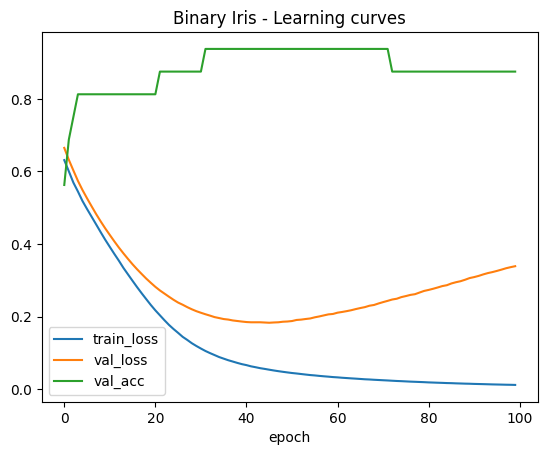

In [8]:
# Plot learning curve (binary Iris)
if 'hist_bin' in globals():
    plt.figure()
    plt.plot(hist_bin["train_loss"], label="train_loss")
    plt.plot(hist_bin["val_loss"], label="val_loss")
    plt.plot(hist_bin["val_acc"], label="val_acc")
    plt.xlabel("epoch"); plt.title("Binary Iris - Learning curves")
    plt.legend(); plt.show()

## Problem 3 Iris - 3‑class model (softmax)
Differences vs binary:
- **Labels** one‑hot with 3 columns.
- **Logits** shape `[None, 3]`.
- **Loss**: `tf.nn.softmax_cross_entropy_with_logits_v2(labels, logits)`.
- **Prediction** via `argmax`.

In [11]:
# Load full Iris (3 classes)
df3 = pd.read_csv("/Iris.csv")
X3 = df3[["SepalLengthCm","SepalWidthCm","PetalLengthCm","PetalWidthCm"]].values.astype("float32")
y3_name = df3["Species"].values

# One-hot encode 3 classes -> DENSE array (handle both old/new sklearn)
from sklearn.preprocessing import OneHotEncoder
try:
    enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # sklearn >=1.2
except TypeError:
    enc = OneHotEncoder(sparse=False, handle_unknown='ignore')         # sklearn <1.2

y3 = enc.fit_transform(y3_name.reshape(-1,1)).astype("float32")  # (150, 3) dense
class_names = list(enc.categories_[0])
print("Classes:", class_names)

# Standardize
from sklearn.preprocessing import StandardScaler
scaler3 = StandardScaler().fit(X3)
X3 = scaler3.transform(X3).astype("float32")

# Splits
from sklearn.model_selection import train_test_split
X3_tr, X3_te, y3_tr, y3_te = train_test_split(X3, y3, test_size=0.20, random_state=42, stratify=y3_name)
X3_tr, X3_va, y3_tr, y3_va = train_test_split(X3_tr, y3_tr, test_size=0.20, random_state=42)

# Hyperparams
lr3 = 1e-3; batch_size3 = 16; epochs3 = 120
n_in = X3_tr.shape[1]; n_h1, n_h2 = 32, 32; n_cls = y3_tr.shape[1]

tf.reset_default_graph()
Xph = tf.placeholder(tf.float32, shape=[None, n_in])
Yph = tf.placeholder(tf.float32, shape=[None, n_cls])

def dense(name, x, in_dim, out_dim, activation=None):
    with tf.variable_scope(name):
        W = tf.get_variable("W", shape=[in_dim, out_dim], initializer=tf.glorot_uniform_initializer())
        b = tf.get_variable("b", shape=[out_dim], initializer=tf.zeros_initializer())
        z = tf.matmul(x, W) + b
        return (activation(z) if activation else z)

h1 = dense("fc1", Xph, n_in, n_h1, activation=tf.nn.relu)
h2 = dense("fc2", h1, n_h1, n_h2, activation=tf.nn.relu)
logits = dense("out", h2, n_h2, n_cls, activation=None)

# If your TF version lacks *_v2, this alias also works:
# loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Yph, logits=logits))
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Yph, logits=logits))

proba = tf.nn.softmax(logits)
pred_idx = tf.argmax(proba, axis=1)
true_idx = tf.argmax(Yph, axis=1)
acc = tf.reduce_mean(tf.cast(tf.equal(pred_idx, true_idx), tf.float32))

train_op = tf.train.AdamOptimizer(lr3).minimize(loss)

hist_multi = {"train_loss":[], "val_loss":[], "val_acc":[]}
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for ep in range(epochs3):
        total = 0.0
        for xb, yb in GetMiniBatch(X3_tr, y3_tr, batch_size=batch_size3, seed=1337+ep):
            _, l = sess.run([train_op, loss], feed_dict={Xph: xb, Yph: yb})
            total += l * len(xb)
        tr_loss = total / len(X3_tr)
        v_loss, v_acc = sess.run([loss, acc], feed_dict={Xph: X3_va, Yph: y3_va})
        hist_multi["train_loss"].append(tr_loss)
        hist_multi["val_loss"].append(float(v_loss))
        hist_multi["val_acc"].append(float(v_acc))
        if (ep+1) % 10 == 0:
            print(f"Epoch {ep+1:03d} | train_loss={tr_loss:.4f}  val_loss={v_loss:.4f}  val_acc={v_acc:.3f}")
    tst_acc = sess.run(acc, feed_dict={Xph: X3_te, Yph: y3_te})
    print("Iris 3-class - Test Accuracy:", float(tst_acc))

Classes: ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
Epoch 010 | train_loss=0.4801  val_loss=0.5757  val_acc=0.750
Epoch 020 | train_loss=0.2805  val_loss=0.4255  val_acc=0.833
Epoch 030 | train_loss=0.1984  val_loss=0.3429  val_acc=0.833
Epoch 040 | train_loss=0.1423  val_loss=0.2864  val_acc=0.875
Epoch 050 | train_loss=0.1039  val_loss=0.2466  val_acc=0.917
Epoch 060 | train_loss=0.0764  val_loss=0.2203  val_acc=0.917
Epoch 070 | train_loss=0.0561  val_loss=0.2054  val_acc=0.917
Epoch 080 | train_loss=0.0441  val_loss=0.2011  val_acc=0.917
Epoch 090 | train_loss=0.0362  val_loss=0.2029  val_acc=0.917
Epoch 100 | train_loss=0.0296  val_loss=0.2055  val_acc=0.917
Epoch 110 | train_loss=0.0263  val_loss=0.2108  val_acc=0.917
Epoch 120 | train_loss=0.0218  val_loss=0.2167  val_acc=0.917
Iris 3-class - Test Accuracy: 0.9333333373069763


Entropy losses reduce with each epoch

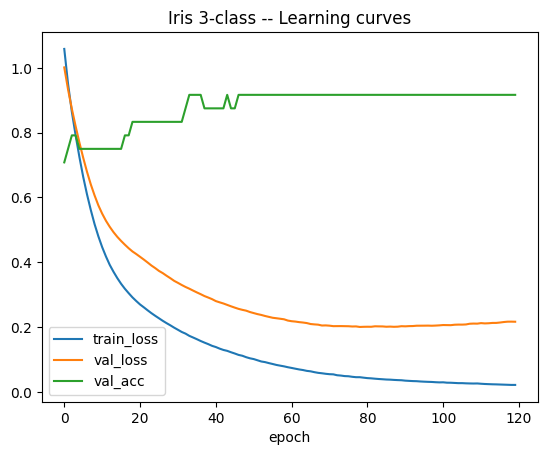

In [12]:
# Plot learning curves (multi-class Iris)
if 'hist_multi' in globals():
    plt.figure()
    plt.plot(hist_multi["train_loss"], label="train_loss")
    plt.plot(hist_multi["val_loss"], label="val_loss")
    plt.plot(hist_multi["val_acc"], label="val_acc")
    plt.xlabel("epoch"); plt.title("Iris 3‑class -- Learning curves")
    plt.legend(); plt.show()

## Question 4 House Prices - Regression (GrLivArea + YearBuilt → SalePrice)
We build a small MLP regressor with MSE loss and report **RMSE**.  
Dataset path: `/mnt/data/train.csv` (from earlier work).


In [13]:

hp_path = "/content/train.csv"
assert os.path.exists(hp_path), "Expected House Prices 'train.csv' at /content/train.csv"
df_hp = pd.read_csv(hp_path)
use_cols = ["GrLivArea","YearBuilt","SalePrice"]
df_hp = df_hp[use_cols].dropna().copy()

Xhp = df_hp[["GrLivArea","YearBuilt"]].values.astype("float32")
yhp = df_hp["SalePrice"].values.astype("float32").reshape(-1,1)

# Optional: log target for stability
log_target = True
if log_target:
    yhp = np.log1p(yhp)

# Split
X_tr, X_te, y_tr, y_te = train_test_split(Xhp, yhp, test_size=0.20, random_state=42)
X_tr, X_va, y_tr, y_va = train_test_split(X_tr, y_tr, test_size=0.20, random_state=42)

# Scale inputs (fit only on train)
sc = StandardScaler().fit(X_tr)
X_tr = sc.transform(X_tr).astype("float32")
X_va = sc.transform(X_va).astype("float32")
X_te = sc.transform(X_te).astype("float32")

# Hyperparams
lr = 1e-3; batch = 32; epochs = 200
n_in = X_tr.shape[1]; n_h1, n_h2 = 64, 32; n_out = 1

tf.reset_default_graph()
Xph = tf.placeholder(tf.float32, shape=[None, n_in])
Yph = tf.placeholder(tf.float32, shape=[None, n_out])

def dense(name, x, in_dim, out_dim, activation=None):
    with tf.variable_scope(name):
        W = tf.get_variable("W", shape=[in_dim, out_dim], initializer=tf.glorot_uniform_initializer())
        b = tf.get_variable("b", shape=[out_dim], initializer=tf.zeros_initializer())
        z = tf.matmul(x, W) + b
        return (activation(z) if activation else z)

h1 = dense("fc1", Xph, n_in, n_h1, activation=tf.nn.relu)
h2 = dense("fc2", h1, n_h1, n_h2, activation=tf.nn.relu)
pred = dense("out", h2, n_h2, n_out, activation=None)

loss = tf.reduce_mean(tf.square(pred - Yph))  # MSE
train_op = tf.train.AdamOptimizer(lr).minimize(loss)

hist_hp = {"train_loss":[], "val_loss":[]}
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for ep in range(epochs):
        total = 0.0
        for xb, yb in GetMiniBatch(X_tr, y_tr, batch_size=batch, seed=999+ep):
            _, l = sess.run([train_op, loss], feed_dict={Xph: xb, Yph: yb})
            total += l * len(xb)
        tr_loss = total / len(X_tr)
        v_loss = sess.run(loss, feed_dict={Xph: X_va, Yph: y_va})
        hist_hp["train_loss"].append(tr_loss)
        hist_hp["val_loss"].append(float(v_loss))
        if (ep+1) % 20 == 0:
            print(f"Epoch {ep+1:03d} | train_MSE={tr_loss:.2f}  val_MSE={v_loss:.2f}")
    # Test RMSE (inverse log if used)
    y_pred_te = sess.run(pred, feed_dict={Xph: X_te})
    if log_target:
        rmse = np.sqrt(mean_squared_error(np.expm1(y_te), np.expm1(y_pred_te)))
    else:
        rmse = np.sqrt(mean_squared_error(y_te, y_pred_te))
    print("House Prices - Test RMSE:", float(rmse))

Epoch 020 | train_MSE=0.51  val_MSE=0.33
Epoch 040 | train_MSE=0.07  val_MSE=0.06
Epoch 060 | train_MSE=0.05  val_MSE=0.05
Epoch 080 | train_MSE=0.04  val_MSE=0.05
Epoch 100 | train_MSE=0.04  val_MSE=0.04
Epoch 120 | train_MSE=0.04  val_MSE=0.04
Epoch 140 | train_MSE=0.04  val_MSE=0.04
Epoch 160 | train_MSE=0.04  val_MSE=0.05
Epoch 180 | train_MSE=0.04  val_MSE=0.04
Epoch 200 | train_MSE=0.04  val_MSE=0.05
House Prices - Test RMSE: 53296.10807554338


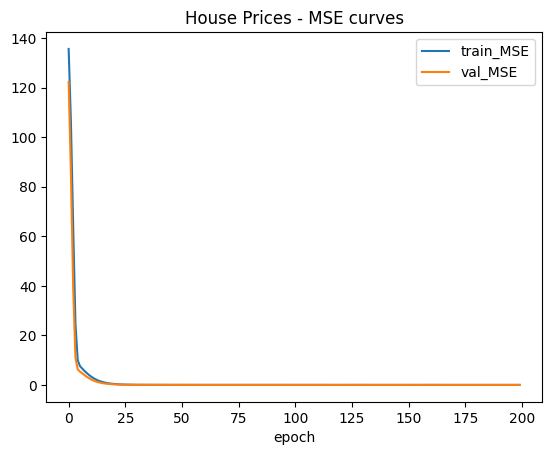

In [14]:
# Plot learning curves (House Prices)
if 'hist_hp' in globals():
    plt.figure()
    plt.plot(hist_hp["train_loss"], label="train_MSE")
    plt.plot(hist_hp["val_loss"], label="val_MSE")
    plt.xlabel("epoch"); plt.title("House Prices - MSE curves")
    plt.legend(); plt.show()


## Question 5 MNIST - Fully connected with TF low‑level
We flatten 28×28 → 784, build a 3‑layer MLP with ReLU, use softmax cross‑entropy, and report accuracy.


In [17]:
# MNIST (TF1-style graph) — robust to TF2 via tf.compat.v1
# !pip install keras
from keras.datasets import mnist
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Make TF1 graph mode work even if TF2 is installed
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()
np.random.seed(42)
tf.compat.v1.set_random_seed(42)


# Load & preprocess MNIST
(Xtr, ytr), (Xte, yte) = mnist.load_data()
Xtr = Xtr.reshape(-1, 784).astype("float32") / 255.0
Xte = Xte.reshape(-1, 784).astype("float32") / 255.0

# Train/val split
Xtr, Xva, ytr, yva = train_test_split(Xtr, ytr, test_size=0.2, random_state=42, stratify=ytr)

# One-hot labels (no sklearn needed)
Ytr = to_categorical(ytr, num_classes=10).astype("float32")
Yva = to_categorical(yva, num_classes=10).astype("float32")
Yte = to_categorical(yte, num_classes=10).astype("float32")


# Hyperparameters & shapes
lr = 1e-3
batch = 128
epochs = 10
n_in = 784
n_h1, n_h2 = 256, 128
n_out = 10


Xph = tf.compat.v1.placeholder(tf.float32, shape=[None, n_in], name="X")
Yph = tf.compat.v1.placeholder(tf.float32, shape=[None, n_out], name="Y")

def dense(name, x, in_dim, out_dim, activation=None):
    with tf.compat.v1.variable_scope(name):
        W = tf.compat.v1.get_variable("W", shape=[in_dim, out_dim],
                                      initializer=tf.compat.v1.glorot_uniform_initializer())
        b = tf.compat.v1.get_variable("b", shape=[out_dim],
                                      initializer=tf.compat.v1.zeros_initializer())
        z = tf.matmul(x, W) + b
        return activation(z) if activation is not None else z

h1 = dense("fc1", Xph, n_in,  n_h1, activation=tf.nn.relu)
h2 = dense("fc2", h1,  n_h1,  n_h2, activation=tf.nn.relu)
logits = dense("out", h2, n_h2, n_out, activation=None)

# Loss / metrics / optimizer
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Yph, logits=logits))
proba = tf.nn.softmax(logits)
pred_idx = tf.argmax(proba, axis=1)
true_idx = tf.argmax(Yph, axis=1)
acc = tf.reduce_mean(tf.cast(tf.equal(pred_idx, true_idx), tf.float32))

train_op = tf.compat.v1.train.AdamOptimizer(lr).minimize(loss)

def iter_minibatches(X, Y, batch_size, seed=None):
    rng = np.random.RandomState(seed)
    idx = rng.permutation(len(X))
    for start in range(0, len(X), batch_size):
        sel = idx[start:start+batch_size]
        yield X[sel], Y[sel]

# Train
hist = {"train_loss": [], "val_loss": [], "val_acc": []}
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    for ep in range(1, epochs+1):
        # one epoch
        total = 0.0
        for xb, yb in iter_minibatches(Xtr, Ytr, batch, seed=2025+ep):
            _, l = sess.run([train_op, loss], feed_dict={Xph: xb, Yph: yb})
            total += l * len(xb)
        tr_loss = total / len(Xtr)
        v_loss, v_acc = sess.run([loss, acc], feed_dict={Xph: Xva, Yph: Yva})
        hist["train_loss"].append(tr_loss)
        hist["val_loss"].append(float(v_loss))
        hist["val_acc"].append(float(v_acc))
        print(f"Epoch {ep:02d} | train_loss={tr_loss:.4f}  val_loss={v_loss:.4f}  val_acc={v_acc:.3f}")

    te_acc = sess.run(acc, feed_dict={Xph: Xte, Yph: Yte})
    print("MNIST - Test Accuracy:", float(te_acc))

Epoch 01 | train_loss=0.3055  val_loss=0.1550  val_acc=0.956
Epoch 02 | train_loss=0.1172  val_loss=0.1134  val_acc=0.966
Epoch 03 | train_loss=0.0751  val_loss=0.0969  val_acc=0.971
Epoch 04 | train_loss=0.0542  val_loss=0.0899  val_acc=0.973
Epoch 05 | train_loss=0.0399  val_loss=0.0840  val_acc=0.975
Epoch 06 | train_loss=0.0314  val_loss=0.0884  val_acc=0.975
Epoch 07 | train_loss=0.0240  val_loss=0.0879  val_acc=0.975
Epoch 08 | train_loss=0.0185  val_loss=0.0969  val_acc=0.975
Epoch 09 | train_loss=0.0137  val_loss=0.0894  val_acc=0.976
Epoch 10 | train_loss=0.0144  val_loss=0.0853  val_acc=0.979
MNIST — Test Accuracy: 0.9793999791145325


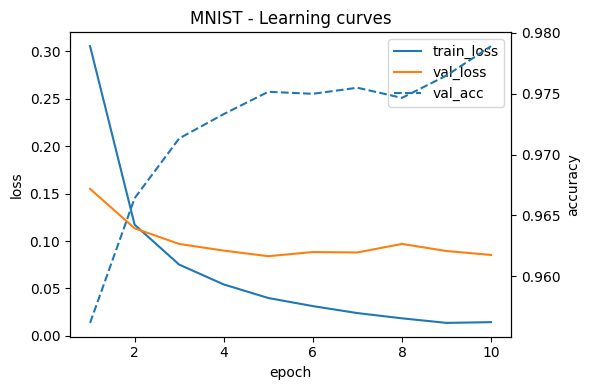

In [18]:
import matplotlib.pyplot as plt

# pick whichever history dict exists
h = globals().get('hist', None) or globals().get('hist_m', None)

if h is not None:
    epochs = range(1, len(h["train_loss"]) + 1)

    fig, ax1 = plt.subplots(figsize=(6,4))
    ax1.plot(epochs, h["train_loss"], label="train_loss")
    ax1.plot(epochs, h["val_loss"], label="val_loss")
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("loss")
    ax1.set_title("MNIST - Learning curves")

    # accuracy on right axis
    ax2 = ax1.twinx()
    ax2.plot(epochs, h["val_acc"], label="val_acc", linestyle="--")
    ax2.set_ylabel("accuracy")

    # combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

    plt.tight_layout()
    plt.show()
else:
    print("No history dict found (expected 'hist' or 'hist_m').")